# CS492 Assignment #1: [ Project Title ]

## Objective

Social Network Service such as Twitter needs contents moderation. This assignment is around that. Specifically, students need to perform the following :

* Understand there's a bias in the classification result
* Implement measures to compute the biasness
* Implement debiasing techniques on data side and post processing side
* Discuss isseus around the bias


 This notebook provides (1) how to build the classifier and (2) skeleton codes for implementing the measurement and debiasing techniques, so students need to fill in. (Ideally,) the result of student coding is automatically synchronized with the visualization: once you update your code for measuring the bias, the results are going to be presented in the visualization tab as well so that you can easily see the improvement. Note that this is for better visualization, not for grading. The objective of this assignment is not optimizing the biasness but do the implementation and discuss around it. More investigation on the code is highly encouraged.

# How to build a classifier?

In this assignment, we are going to build the classifier that classifies whether a tweet needs to be moderated. Especially, we are going to use supervised learning for building the classifier. To do that, we are going to follow the procedure below:

    1. Import dataset
    2. Preprocess the dataset    -- Debiasing technique is needed here
    3. Train the model (includes post-processing mechanism).    -- Debiasing technique is needed here
    4. Evaluate the model
    5. See the classification result with totally new tweets
        5-1. Import dataset
        5-2. Predict
        5-3. See the result
    
From now, we're going to go through each step deeply.

## 1. Import dataset

We first import the dataset. The original dataset is .csv, and we're going to load the data and do formatting. Here, formatting means that the label column name should be "class", and tweet column name should be "tweet"

In [1]:
# !conda install -c conda-forge textstat --yes

import process

datasetInfo = {
    'filename': 'david.csv',                      # the filename
    'code': 'david',
    'label': ['Hate', 'Offensive', 'Neither']     # Labels
}

data = process.dataImporting(datasetInfo['filename'])
formattedData = process.dataFormatting(data, datasetInfo['code'])
    
formattedData

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


## 2. Preprocess the dataset

We are going to preprocess the data. We are going to vectorize each tweet and use TF-IDF to generate a matrix.

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

result = process.dataPreprocessing(formattedData)

result['M']


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...


Feature generation ...


/home/ubuntu/anaconda3/envs/jupyterhub_prime/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(24783, 4023)
TfidfVectorizer(decode_error='replace', max_df=0.75, max_features=10000,
                min_df=5, ngram_range=(1, 3), norm=None,
                preprocessor=<function dataPreprocessing.<locals>.preprocess at 0x7f4a72c01cb0>,
                smooth_idf=False,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function dataPreprocessing.<locals>.tokenize at 0x7f4a72c01d40>)
['b', 'b b', 'b b b', 'b b c', 'b b e', 'b b f', 'b b g', 'b b h', 'b b k', 'b b l', 'b b n', 'b b p', 'b b q', 'b b r', 'b b u', 'b b w', 'b c', 'b c b', 'b c c', 'b c e', 'b c f', 'b c g', 'b c h', 'b c 

array([[1.29163073, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [2.58326146, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [2.58326146, 0.        , 0.        , ..., 2.        , 0.        ,
        1.        ],
       ...,
       [1.29163073, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.29163073, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.58326146, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

## 3. Train the model

Now we're going to train the model.

In [11]:
result2 = process.buildModel(result)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.4s finished


## 4. Evaluate the model

              precision    recall  f1-score   support

           0       0.45      0.59      0.51       164
           1       0.96      0.91      0.94      1905
           2       0.83      0.94      0.88       410

    accuracy                           0.89      2479
   macro avg       0.75      0.81      0.77      2479
weighted avg       0.91      0.89      0.90      2479



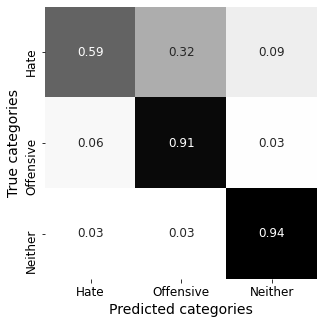

In [14]:
result3 = process.evaluateModel(result2, datasetInfo['label'])

## 5. See the classification result and see there's bias

Now we're going to use the model to classify a totally new tweet dataset. To do that, we are going to import another dataset, predict, and see the result

## 5-1. Import dataset

In [16]:
import pandas as pd

filepath='./blackTweets_0.5.txt'
tweetList = []

cnt = 0

with open(filepath) as fp:
    for line in fp :
        tweetList.append(line.strip())
        cnt = cnt + 1
        
        line = fp.readline()

blackTweet = pd.DataFrame(data={'tweet': tweetList, 'class': [0 for i in range(len(tweetList))]})

filepath='./whiteTweets_0.5.txt'
tweetList = []

cnt = 0

with open(filepath) as fp:
    for line in fp :
        tweetList.append(line.strip())
        cnt = cnt + 1
        
        line = fp.readline()

whiteTweet = pd.DataFrame(data={'tweet': tweetList, 'class': [1 for i in range(len(tweetList))]})

# Disucssion items

### Dataset, Model, and Performance

0. Explore the raw tweets. What did you observe? Was there any significant difference on tweets between classes?

1. Let's say we released the trained logistic regression model, which has been initially given without debiasing techniques, for twitter contents moderation. 
    1-1. What do you expect?
    1-2. What would be possible consequences?
    1-3. Do you think it is socially acceptable?
    1-4. If you think it needs to be improved, what would be the possible solution?

2. The dataset is highly skewed. The dataset1 contains 80% of "Abusive" tweets, but the dataset 2 contains only 5% of "hateful" tweets.
    2-1. The way we collect the data significantly affects such skew as well as the overall distribution of labels. Why do we observe such skew for these two specific datasets? You may want to refer to the data collection methods described in the paper.
    2-2. How does the skewness need to be handled? Is it an ultimate goal to reduce such skew and balance all the labels? Then how can we determine whether the current dataset is enough (i.e. balanced)?
    2-3. Let's say you are going to collect dataset again to train the logistic regression model. How would you design the data collection pipeline? Explain the rationale.

3. Do you think the way we train the model (i.e. data preprocessing and the model selection) contributed to the biased result? Note that we have used n-grams (n <= 3) as a vocabulary and TF-IDF as the feature.

4. The trained logistic regression model performed pretty well (weighted avg of F1-score: XYZ), although the model gives a racially biased prediction result.
    4-1. One might say that model performance was enough to be deployed, so we can conclude that the African-American English is more hateful and abusive. Discuss.

5. What would be the possible source of bias?
    5-1. Dataset: 
    5-2. Preprocessing:
    5-3. Model:
    5-4. Measuring performance:
    5-5. Measuring Bias:


### Measuring bias

6. We used XYZ to measure the bias. Discuss what is captured well and what's not captured for each measure. Also, discuss which measures we need to use for which situations.

7. Would it be okay to optimize towards a single bias measure? When do you think it is acceptable? When not?

8. Have you observed anything on relationship between the model performance and bias measure, even it is not significant in our assignment? If so, describe it with your opinions on why such relationship could exist.



### Debiasing

9. We introduced two debiasing techniques, undersampling and post-processing. 
    1-1. Why do you think undersampling reduced a measure of bias? Can you imagine when it doesn't work?
    1-2. Why do you think the post-processing reduced a measure of bias? Can you imagine when it doesn't work?

10. The measure of bias on "Hateful" label increased whereas that on "Abusive" gets decreased. Why do you think it happened? Can we achieve the measures on both label get improved?

11. Is debiasing always necessary? When do we need debiasing? When not?

12. Is there 'completely unbiased' prediction results? What does that mean?


### Overall process of this assignment

13. We used AAE/SAE classifier throughout the process. How can it affect the result?



